# Saqeeb's Pokedex


Welcome to my own personal Pokedex, where I'll be using a residual neural network to build a classifier that can identify any of the original 151 pokemon!


First, we need to grab the data. Luckily there is already a nice dataset on kaggle.com.
It is, however, missing two pokemon: the male and female nidorans. I'm planning to gather the data for this later. Right now we'll be training with 149 classes.


In [4]:
import scipy
import cv2
import opendatasets as od

dataset_url = 'https://www.kaggle.com/thedagger/pokemon-generation-one' # You will need a kaggle token for this
od.download(dataset_url)

Skipping, found downloaded files in ".\pokemon-generation-one" (use force=True to force download)


In [5]:
import os

DATA_DIR = './pokemon-generation-one/dataset'
classes = os.listdir(DATA_DIR)
print(classes)

['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Nidoqueen', 'Nidorina'

To normalize the images, we first have to calculate the mean and standard deviation of the dataset. This takes a while and is bottlenecked by my HDD, so we'll try to read it from a file, and if the file doesn't exist, we'll calculate it manually and save it to a file for next time.

In [6]:
import json
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt


def mean_std(batch):
    '''Calculate the means and standard deviations of all images in a batch by channel'''
    images, labels = next(iter(batch))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

try:
    with open('stats.data', 'r') as filehandle: # open file for reading
        stats = json.load(filehandle)
    print("Loaded mean and standard deviation from file.")
    print(stats)
    write = False
except:
    print("stats.data does not exist in the root directory. Calculating the mean and standard deviation:")
    write = True

if write:
    # Create a temporary dataset to get the mean and std

    image_size = 128

    stats_tfms = tt.Compose([tt.Resize(image_size),
                            tt.CenterCrop(image_size),
                            tt.ToTensor()])

    stats_set = ImageFolder(DATA_DIR, stats_tfms)
    dl = DataLoader(stats_set, batch_size=len(stats_set))

    mean, std = mean_std(dl)
    stats = mean.tolist(), std.tolist()
    print(stats)

    with open('stats.data', 'w') as filehandle: # open file for writing
        json.dump((stats), filehandle)
    print("Stats saved in stats.data.")

stats.data does not exist in the root directory. Calculating the mean and standard deviation:


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Now we need to standardize the dataset in terms of image size. Due to memory constraints, each image should be no more than 128x128 pixels. Below, I create two instances of the dataset. That's because I don't have the files separated into training and validations sets, so instead I applied two random_split()s with the same seed. This allows for the training and validation sets to have different transformations/augmentations applied to them.

In [69]:
image_size = 128
batch_size = 64
stats = mean, std

# train_tfms = tt.Compose([tt.Resize(image_size),
#                          tt.CenterCrop(image_size),
#                          tt.RandomCrop(image_size, padding=8, padding_mode='reflect'), 
#                          tt.RandomHorizontalFlip(), 
#                          # tt.RandomRotate
#                          # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#                          # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
#                          tt.ToTensor(),
#                          tt.Normalize(*stats,inplace=True)])

train_tfms = tt.Compose([tt.Resize(image_size),
                         # tt.Resize(image_size, max_size=image_size),
                         # tt.Pad(padding=[(128 - image[0])/2 if image[0]<128 else 0, (128 - image[1])/2 if image[1]<128 else 0]),
                         tt.CenterCrop(image_size),
                         tt.RandomCrop(image_size, padding=8, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.Resize(image_size),
                         tt.CenterCrop(image_size),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

dataset  = ImageFolder(DATA_DIR, train_tfms)
dataset2 = ImageFolder(DATA_DIR, valid_tfms)


Now we split the dataset into training and validation sets, with a seed for consistency and reproducibility.

In [70]:
from torch.utils.data import random_split

random_seed = 42
torch.manual_seed(random_seed);

valid_percent = 0.2
valid_size = int(valid_percent * len(dataset))
train_size = len(dataset) - valid_size

train_ds,  valid_ds  = random_split(dataset,  [train_size, valid_size]) # has the train_tfms transforms

torch.manual_seed(random_seed);
train_ds2, valid_ds2 = random_split(dataset2, [train_size, valid_size]) # has the valid_tfms transforms

del train_ds2
del valid_ds

len(train_ds), len(valid_ds2), len(dataset) # Sanity check

(8524, 2131, 10655)

Now let's set up some data loaders. I'll start with a batch size of 64, and increase it if it's training too slowly and I have extra GPU memory.

In [81]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_dl = DataLoader(valid_ds2, batch_size*2, num_workers=0, pin_memory=True)

Let's take a look at some of the images to make sure nothing went wrong so far.

In [76]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
    # return (images-means)/stds

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


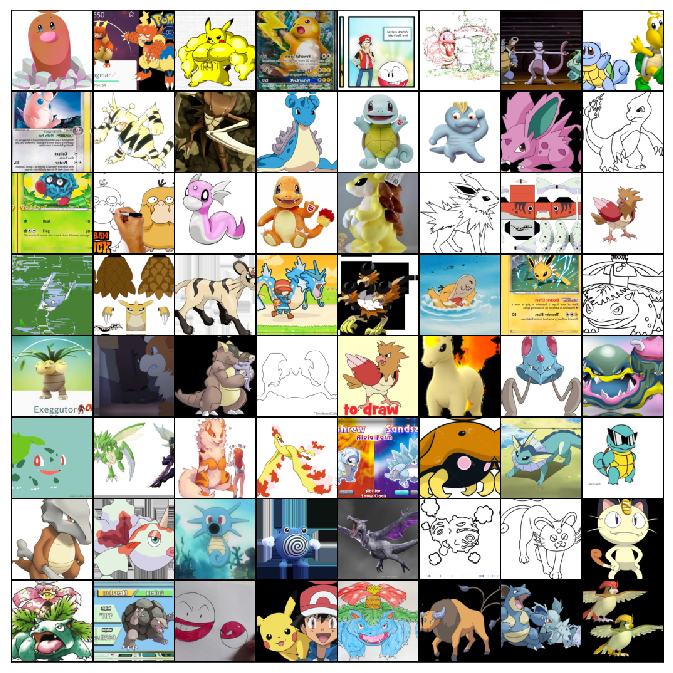

In [77]:
show_batch(train_dl)

In [94]:
for images, labels in train_dl: # Sanity check
    print(images.shape)
    break

torch.Size([64, 3, 128, 128])


## Loading data onto the GPU

Alright, we've got all our data formatted and ready to go! Let's load everything onto the GPU.

In [99]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We created a wrapper `DeviceDataLoader` to wrap around our dataloaders and transfer them to the GPU.

In [100]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

cuda


## Creating the model

We'll start with a 9 layer ResNet as described [here](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/). The layers are shown in this image:

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)